In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob, os
import pandas as pd
import keras
import numpy as np
np.random.seed(1337)  # for reproducibility
########################
from tqdm import tqdm
from random import shuffle as shuffle_array
from sklearn.model_selection import StratifiedKFold
########################
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,  Convolution1D,Convolution2D, MaxPooling2D , AveragePooling2D
from keras.utils import np_utils
from keras.layers.core import Reshape
########################

In [3]:
df_data=pd.read_csv('/content/drive/My Drive/data1111.csv')
print(df_data.shape)
df_data

(1002551, 10)


,timestamp,a_x,a_y,a_z,a_mag,g_x,g_y,g_z,g_mag,id
0,9.243300e+14,18.015320,3.599411,5.384979,19.144334,-2.535614,1.696365,0.348312,3.070556,1
1,9.243300e+14,17.810730,3.810242,10.976013,21.265298,-2.563705,1.911408,0.206589,3.204488,1
2,9.243300e+14,16.739166,4.328003,13.389572,21.868057,-2.591812,1.917511,0.005020,3.224029,1
3,9.243300e+14,15.518249,4.258362,12.666992,20.479316,-2.610138,1.610855,-0.257629,3.077994,1
4,9.243300e+14,14.924393,3.223434,10.964874,18.797779,-2.601593,0.940140,-0.538651,2.818207,1
...,...,...,...,...,...,...,...,...,...,...
1002546,8.958240e+14,-1.102799,7.916641,0.713028,8.024823,-0.628677,-0.847488,0.869904,1.367554,23
1002547,8.958240e+14,-0.893311,7.816086,0.613663,7.890867,-0.478485,-0.767593,0.784149,1.197095,23
1002548,8.958240e+14,-0.677826,7.682022,0.628036,7.737399,-0.324020,-0.651474,0.707977,1.015204,23
1002549,8.958240e+14,-0.583252,7.616180,0.781265,7.678331,-0.178604,-0.518845,0.640335,0.843284,23


In [4]:
Ns = 200 #size of each of contiguous chunk
N_samples=df_data.shape[0]//Ns
rounded_data_idx = N_samples*Ns

col_sensors=[u'a_x', u'a_y', u'a_z', u'a_mag',u'g_x',u'g_y',u'g_z',u'g_mag']
# col_sensors=[ u'a_mag']
X_train_test=df_data.loc[:,col_sensors][:rounded_data_idx].to_numpy().T.reshape(N_samples,8,200,1)
y_train_test_vec=df_data.loc[:,'id'][:rounded_data_idx].values[0::Ns]

from random import shuffle as shuffle_array
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# For an 80-20 split
# skf =StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
skf=StratifiedKFold(n_splits=5,shuffle=True)
ind_split=skf.split(np.zeros(N_samples), y_train_test_vec)
train_indices=ind_split.__next__()[0]
test_indices=ind_split.__next__()[1]
shuffle_array(train_indices)
shuffle_array(test_indices)

y_train=y_train_test_vec[train_indices]
y_test=y_train_test_vec[test_indices]

X_train=X_train_test[train_indices,:,:,:]
X_test=X_train_test[test_indices,:,:,:]

In [5]:
nb_classes=23
# convert class vectors to binary class matrices
#Note that we need to subtract 1 from the user_label to get class label
# that begin at 0
Y_train = np_utils.to_categorical(y_train-1, nb_classes)
Y_test = np_utils.to_categorical(y_test-1, nb_classes)
print(X_train.shape)
print(X_test.shape)

(4009, 8, 200, 1)
(1003, 8, 200, 1)


In [6]:
# cnn lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from matplotlib import pyplot


In [8]:
def IDNet_cnn_keras(weights_path=None, img_rows=8, img_cols=200):
    nb_classes = 23
    # size of pooling area for max pooling
    nb_pool = 3
    ###############################################################
    ###############################################################
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(img_rows,img_cols,1)))
    print(model.output_shape)
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    print(model.output_shape)
    model.add(TimeDistributed(Dropout(0.5)))
    print(model.output_shape)
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    print(model.output_shape)
    model.add(TimeDistributed(Flatten()))
    print(model.output_shape)
    model.add(LSTM(100))
    print(model.output_shape)
    model.add(Dropout(0.5))
    print(model.output_shape)
    model.add(Dense(100, activation='relu'))
    print(model.output_shape)
    model.add(Dense(nb_classes, activation='softmax'))
    print(model.output_shape)
    return model
model = IDNet_cnn_keras()
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

History=model.fit(X_train, Y_train, batch_size=128,validation_split=0.125, epochs=100,verbose=1)
score = model.evaluate(X_test, Y_test, verbose=1)
model.save("/content/drive/My Drive/file h5/cnnLSTM100-23class.h5")
print('Test score:', score[0])
print('Test accuracy:', score[1])

(None, 8, 198, 64)
(None, 8, 196, 64)
(None, 8, 196, 64)
(None, 8, 98, 64)
(None, 8, 6272)
(None, 100)
(None, 100)
(None, 100)
(None, 23)
Epoch 1/100
 8/28 [=======>......................] - ETA: 18s - loss: 3.1675 - accuracy: 0.0420

KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 8, 198, 64)        256       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 8, 196, 64)        12352     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 8, 196, 64)        0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 8, 98, 64)         0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 8, 6272)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               2549200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)              

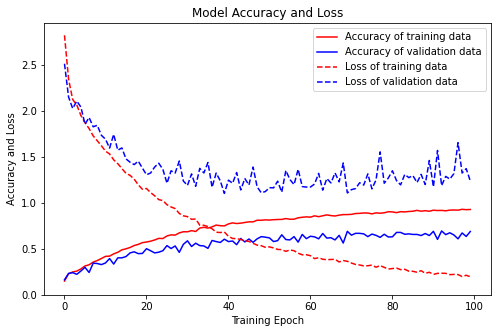

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(History.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(History.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(History.history['loss'], 'r--', label='Loss of training data')
plt.plot(History.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


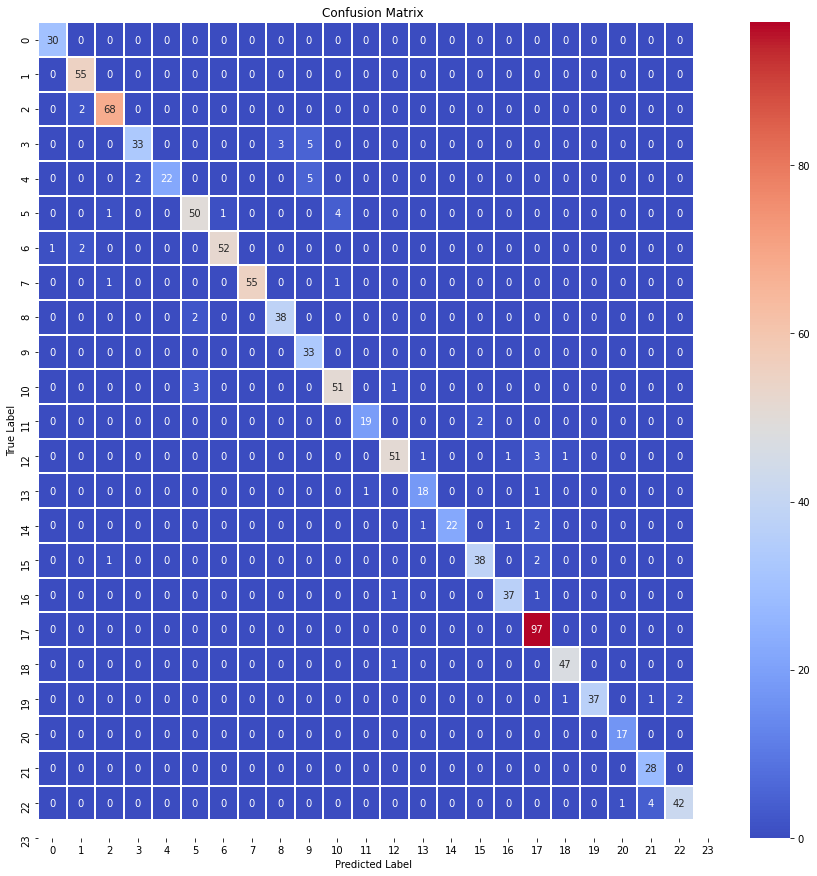

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.93      1.00      0.96        55
           2       0.96      0.97      0.96        70
           3       0.94      0.80      0.87        41
           4       1.00      0.76      0.86        29
           5       0.91      0.89      0.90        56
           6       0.98      0.95      0.96        55
           7       1.00      0.96      0.98        57
           8       0.93      0.95      0.94        40
           9       0.77      1.00      0.87        33
          10       0.91      0.93      0.92        55
          11       0.95      0.90      0.93        21
          12       0.94      0.89      0.92        57
          13       0.90      0.90      0.90        20
          14       1.00      0.85      0.92        26
          15       0.95      0.93      0.94        41
          16       0.95      0.95      0.95        39
          17       0.92    

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

LABELS=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
        '15','16','17','18','19','20','21','22','23']
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(15, 15))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

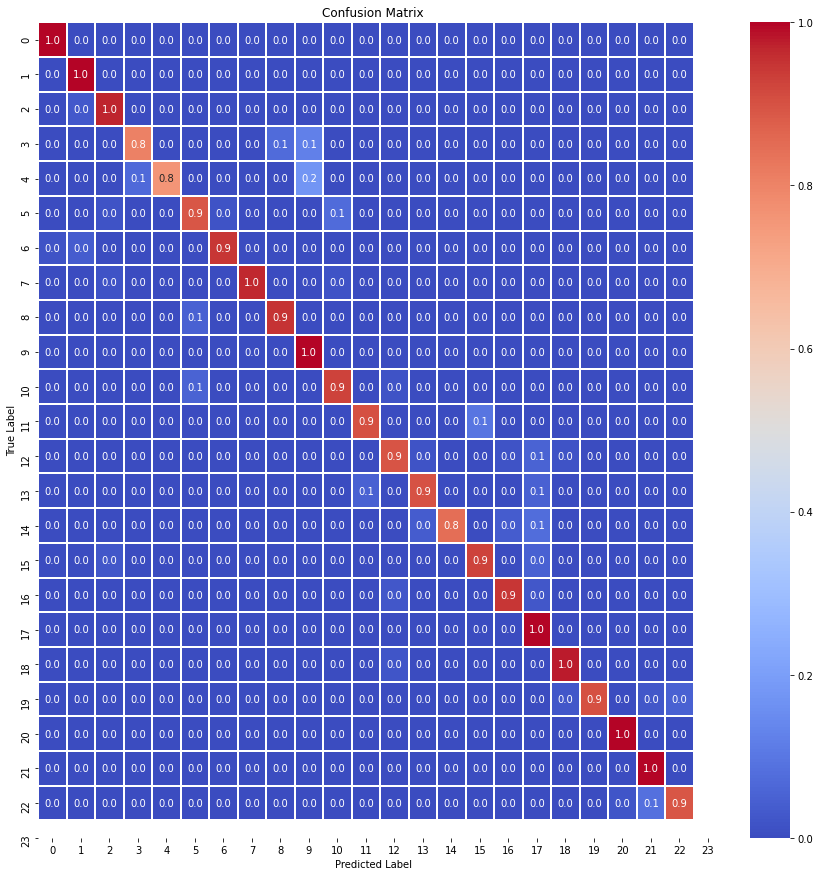

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.93      1.00      0.96        55
           2       0.96      0.97      0.96        70
           3       0.94      0.80      0.87        41
           4       1.00      0.76      0.86        29
           5       0.91      0.89      0.90        56
           6       0.98      0.95      0.96        55
           7       1.00      0.96      0.98        57
           8       0.93      0.95      0.94        40
           9       0.77      1.00      0.87        33
          10       0.91      0.93      0.92        55
          11       0.95      0.90      0.93        21
          12       0.94      0.89      0.92        57
          13       0.90      0.90      0.90        20
          14       1.00      0.85      0.92        26
          15       0.95      0.93      0.94        41
          16       0.95      0.95      0.95        39
          17       0.92    

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
LABELS=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
        '15','16','17','18','19','20','21','22','23']
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions,normalize='true')
    plt.figure(figsize=(15, 15))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='.1f')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

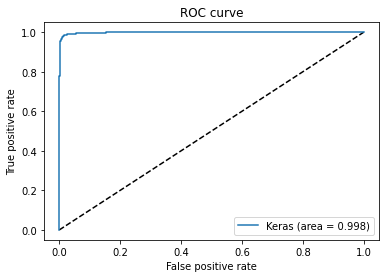

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test.flatten(), y_pred_keras.flatten())
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
